In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json


import scanpy
import anndata
import shap
import xgboost

from tqdm import tqdm

shap.initjs()

for some reason for ML model (trained on Geuvadis-BRAIN0 common transcripts) eval on BRAIN0 has bad quality
![alt text](image.png)

In [76]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'

organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][0]

#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'


value_to_predict = 'Sex'

sex = ['chrXY', 'chrX'][0]

In [77]:
with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

In [78]:

data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

features = pd.read_hdf(
    fdir_processed / f'feature_importance.{"xgboost"}.{value_to_predict}.h5',
    key=f'{sex}',
)

features = features[feature_importance_method]
features = features.sort_values(ascending=False)

if organ != "None":
    fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
    fname = fname.name

    data_eval_ = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
    features = features.loc[features.index.intersection(data_eval_.columns)]
    print(features.shape)

features_list = features

# features_fname = f"geuvadis_features_{sex}_calibration_{organ}.csv"
# features_list.to_csv(ml_models_fdir / model_type / features_fname)

data = data[features_list.index]
# print(features_list)

X_train = data.values

train_scaler = StandardScaler().fit(X_train)
X_train = StandardScaler().fit_transform(X_train)


data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
y_train = data_header['Sex']
y_train = LabelEncoder().fit_transform(y_train)

proba = np.zeros(shape=(X_train.shape[0], 2))
pred = np.zeros(shape=(X_train.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(5):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X_train)
    pred_ = model.predict(X_train)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y_train, pred_))
    f1.append(f1_score(y_train, pred_))
    precisions.append(precision_score(y_train, pred_))
    recalls.append(recall_score(y_train, pred_))

    # viz = RocCurveDisplay.from_predictions(
    #     y, model.predict_proba(X)[:, 1], ax=None
    #     # ax=ax,
    # )
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    # interp_tpr[0] = 0
    # tprs.append(interp_tpr)
    
proba = proba / 5
# # pred = pred / 5
# if sex == 'autosome':
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# else:
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# # print(pred.astype(int))

# # mean_tpr = np.mean(tprs, axis=0)
# # mean_tpr[-1] = 1.0

# mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
# print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

# print(features_list)


(9641,)
--------------------
mean_accuracy=0.9814092953523238,
mean_f1=0.9815035914421193,
mean_precision=0.9666431230259039,
mean_recall=0.9969604863221884,
--------------------
```


--------------------
mean_auc=0.994949494949495,
mean_accuracy=0.9705882352941176,
mean_f1=0.9795918367346939,
mean_precision=1.0,
mean_recall=0.96,
--------------------
```


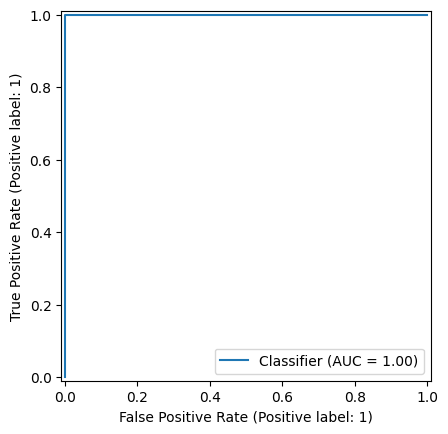

In [86]:

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')
# data_eval_header = data_eval_header.loc(data_eval.index)
# print(data_eval_header.columns)
# print('ground true: ', (data_eval_header['sex'].values == 'male').astype(int))

features_fname = f"geuvadis_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]

X_eval = data_eval.values
y_eval = data_eval_header['sex'].values

label_encoder = LabelEncoder().fit(y_eval)
y_eval = label_encoder.transform(y_eval)

train_scaler = StandardScaler().fit(X_eval)
X_eval = StandardScaler().fit_transform(X_eval)
X_eval[:, 5] = X_eval[:, 5] - 0.25

proba = np.zeros(shape=(X_eval.shape[0], 2))
pred = np.zeros(shape=(X_eval.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(1):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X_eval)
    pred_ = model.predict(X_eval)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y_eval, pred_))
    f1.append(f1_score(y_eval, pred_))
    precisions.append(precision_score(y_eval, pred_))
    recalls.append(recall_score(y_eval, pred_))

    viz = RocCurveDisplay.from_predictions(
        y_eval, model.predict_proba(X_eval)[:, 1], ax=None
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)
    
proba = proba / 5
# # pred = pred / 5
# if sex == 'autosome':
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# else:
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# # print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

# print(features_list)

In [80]:
(data.columns == data_eval.columns).min()

True

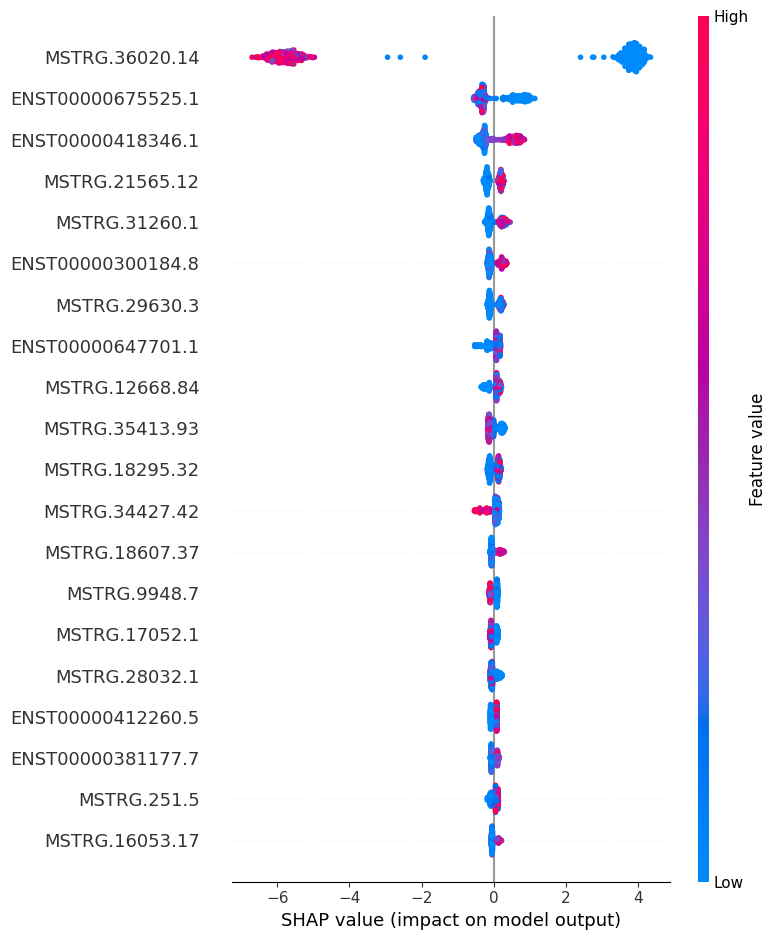

In [81]:
X_train = pd.DataFrame(data=X_train, columns=data.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_train)

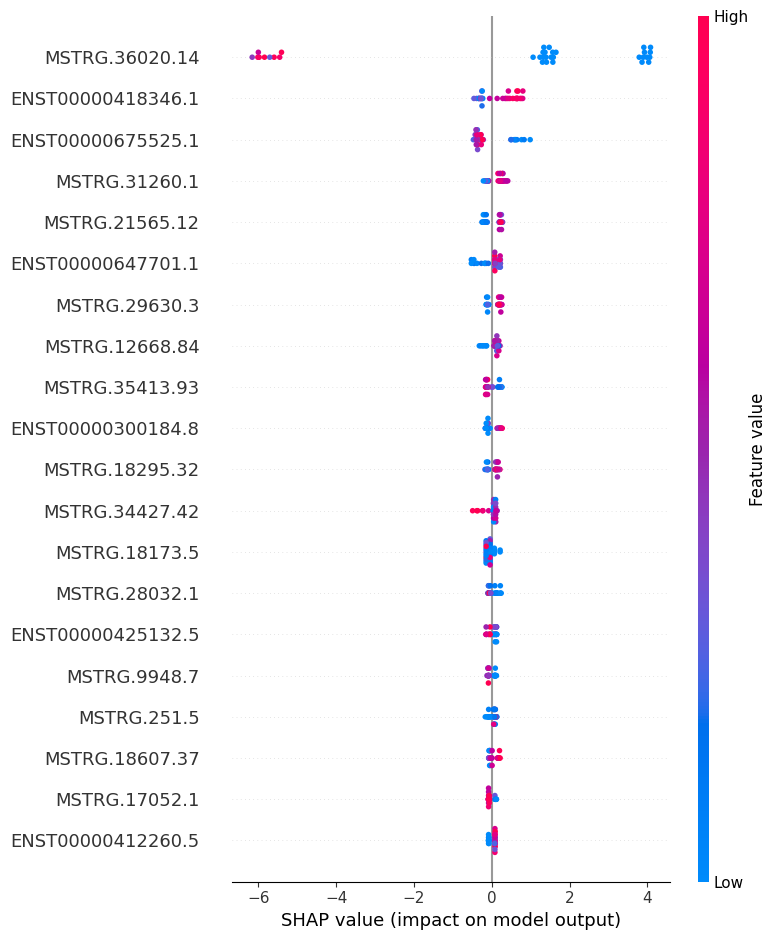

In [82]:
X_eval = pd.DataFrame(data=X_eval, columns=data_eval.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval)
shap.summary_plot(shap_values, X_eval)
# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_eval)

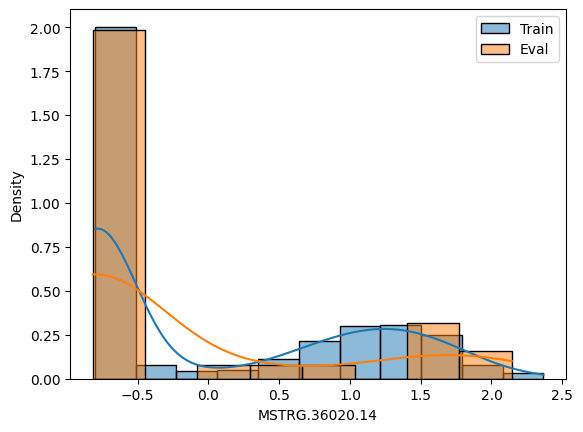

In [83]:
# sns.kdeplot(
#     data['MSTRG.36020.14']
# )
sns.histplot(
    X_train['MSTRG.36020.14'], kde=True, stat='density', label='Train'
    # data['MSTRG.35413.93'], kde=True, stat='density'
)
sns.histplot(
    X_eval['MSTRG.36020.14'], kde=True, stat='density', label='Eval'
    # data_eval['MSTRG.35413.93'], kde=True, stat='density'
)
plt.legend()



In [84]:
X_train['MSTRG.36020.14'].min(), X_eval['MSTRG.36020.14'].min()

(-0.8027743, -0.81914556)